In [6]:
import os
import sys

import sys
sys.path.append('../')  # Adding the core library

from maze.models import EfficientUNet
from maze.datasets import FishHeatmapDataset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

# Dataset

Create a construct which loads the data based in COCO format, with additional heatmaps stored separately, with same naming as the source image.

In [7]:
joint_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
])
joint_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
])

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Preload the data

We preload the data into DDR memory, as its not so big, and it speeds up the training process massively.

In [8]:
train_ds = FishHeatmapDataset(
    annotation_json="../data/training/coco/annotations_train.json",
    image_dir='../data/training/coco/images/',
    background_dir='../data/training/coco/backgrounds/',
    background_prob=0.3,
    heatmap_dir='../data/training/coco/heatmaps/',
    joint_transform=joint_train,
    img_transform=img_transform,
)

val_ds = FishHeatmapDataset(
    annotation_json="../data/training/coco/annotations_val.json",
    image_dir='../data/training/coco/images/',
    heatmap_dir='../data/training/coco/heatmaps/',
    background_dir='../data/training/coco/backgrounds/',
    background_prob=0.3,
    joint_transform=joint_val,
    img_transform=img_transform,
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)

# Trainig

Let's setup our loss, optimizer etc.
1. **Loss**: we use Mean Squared Error (MSE) between predicted heatmap and target. It's simple and works well since both are smooth distribution
2. **Optimizer**: AdamW 
3. **LR scheduler**: ReduceLROnPlateau 

Later we run the training loop. 

In [9]:
# 1. Device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 2. Initialize the model
model = EfficientUNet()

# Freeze first 3 stages of the encoder (enc1 to enc3)
for param in model.enc1.parameters():
    param.requires_grad = False
for param in model.enc2.parameters():
    param.requires_grad = False
for param in model.enc3.parameters():
    param.requires_grad = False

model = model.to(device)

# 3. Loss setup
mse_loss_fn = torch.nn.MSELoss()
alpha = 1.0

def get_centroid(heatmap):
    # return None if heatmap is empty (sums to 0)
    if heatmap.sum() < 1e-8:
        return None

    b, _, _, w = heatmap.shape
    flat_idx = torch.argmax(heatmap.view(b, -1), dim=1)
    y = flat_idx // w
    x = flat_idx % w

    return x.float(), y.float()

def centroid_distance_loss(pred, target):
    result = get_centroid(pred)
    if result is None:
        return torch.tensor(0.0).to(device)

    x_pred, y_pred = result
    x_gt, y_gt = get_centroid(target)
    dist = torch.sqrt((x_pred - x_gt)**2 + (y_pred - y_gt)**2 + 1e-8)
    return dist.mean()

# 4. Optimizer & scheduler (unchanged)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)


Using device: cuda


In [10]:
# 5. Training Loop Setup
epochs = 40
epoch_save_interval = 5

model_dir = '../data/models/efficientunet'
log_dir = f'{model_dir}/runs'
checkpoint_dir = f'{model_dir}/checkpoints'

os.makedirs(checkpoint_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir, flush_secs=1)

best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
    for imgs, heatmaps in train_bar:
        imgs = imgs.to(device)
        heatmaps = heatmaps.to(device)

        preds = model(imgs)
        
        mse = mse_loss_fn(preds, heatmaps)
        cdist = centroid_distance_loss(preds, heatmaps)
        loss = mse + alpha * cdist

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())
        train_bar.set_postfix(mse=mse.item(), cdist=cdist.item())

    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
    with torch.no_grad():
        for imgs, heatmaps in val_bar:
            imgs = imgs.to(device)
            heatmaps = heatmaps.to(device)

            preds = model(imgs)

            mse = mse_loss_fn(preds, heatmaps)
            cdist = centroid_distance_loss(preds, heatmaps)
            loss = mse + alpha * cdist

            val_loss += loss.item()
            val_bar.set_postfix(loss=loss.item())
            val_bar.set_postfix(mse=mse.item(), cdist=cdist.item())

    val_loss /= len(val_loader)
    scheduler.step(val_loss)

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'{model_dir}/best_model.pth')

    # Save model checkpoint every N epochs
    if (epoch + 1) % epoch_save_interval == 0:
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth'))

writer.close()

Epoch 1/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 1/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train Loss = 104.4166, Val Loss = 137.9590


Epoch 2/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 2/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2: Train Loss = 140.0737, Val Loss = 121.3773


Epoch 3/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 3/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3: Train Loss = 104.8701, Val Loss = 89.6526


Epoch 4/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 4/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4: Train Loss = 76.2937, Val Loss = 42.2110


Epoch 5/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 5/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5: Train Loss = 63.5745, Val Loss = 24.3075


Epoch 6/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 6/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6: Train Loss = 50.9084, Val Loss = 15.6909


Epoch 7/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 7/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7: Train Loss = 47.2978, Val Loss = 12.4013


Epoch 8/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 8/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8: Train Loss = 43.5994, Val Loss = 10.7156


Epoch 9/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 9/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9: Train Loss = 41.7474, Val Loss = 10.5396


Epoch 10/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 10/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10: Train Loss = 39.0609, Val Loss = 10.3284


Epoch 11/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 11/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11: Train Loss = 36.4933, Val Loss = 9.5523


Epoch 12/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 12/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12: Train Loss = 35.1530, Val Loss = 9.0872


Epoch 13/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 13/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13: Train Loss = 36.5603, Val Loss = 8.9384


Epoch 14/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 14/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14: Train Loss = 34.1737, Val Loss = 8.7649


Epoch 15/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 15/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15: Train Loss = 34.4582, Val Loss = 8.9412


Epoch 16/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 16/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16: Train Loss = 31.0929, Val Loss = 8.6621


Epoch 17/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 17/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17: Train Loss = 32.4040, Val Loss = 8.9711


Epoch 18/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 18/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18: Train Loss = 34.0947, Val Loss = 8.7873


Epoch 19/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 19/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19: Train Loss = 30.8433, Val Loss = 8.6375


Epoch 20/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 20/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20: Train Loss = 30.6725, Val Loss = 8.3627


Epoch 21/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 21/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21: Train Loss = 30.1073, Val Loss = 8.4942


Epoch 22/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 22/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22: Train Loss = 30.2539, Val Loss = 8.4906


Epoch 23/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 23/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23: Train Loss = 29.9710, Val Loss = 8.8539


Epoch 24/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 24/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24: Train Loss = 27.0403, Val Loss = 8.5308


Epoch 25/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 25/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25: Train Loss = 27.4865, Val Loss = 8.3501


Epoch 26/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 26/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26: Train Loss = 28.4731, Val Loss = 8.2693


Epoch 27/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 27/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27: Train Loss = 27.1165, Val Loss = 8.2730


Epoch 28/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 28/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28: Train Loss = 28.9689, Val Loss = 8.2658


Epoch 29/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 29/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29: Train Loss = 26.5323, Val Loss = 8.2353


Epoch 30/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 30/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30: Train Loss = 25.0192, Val Loss = 7.9470


Epoch 31/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 31/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31: Train Loss = 24.8533, Val Loss = 7.8944


Epoch 32/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 32/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32: Train Loss = 25.5169, Val Loss = 7.9698


Epoch 33/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 33/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33: Train Loss = 25.0909, Val Loss = 7.4096


Epoch 34/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 34/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34: Train Loss = 23.7065, Val Loss = 7.4407


Epoch 35/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 35/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35: Train Loss = 24.2996, Val Loss = 7.4894


Epoch 36/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 36/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36: Train Loss = 23.7040, Val Loss = 7.1233


Epoch 37/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 37/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37: Train Loss = 24.0413, Val Loss = 7.0307


Epoch 38/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 38/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38: Train Loss = 22.9384, Val Loss = 6.8422


Epoch 39/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 39/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39: Train Loss = 22.9131, Val Loss = 7.0109


Epoch 40/40 [Train]:   0%|          | 0/172 [00:00<?, ?it/s]

Epoch 40/40 [Val]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40: Train Loss = 22.2123, Val Loss = 6.7399


# Model Validation

Now let's put model through numerous tests to see how well it performs.

In [11]:
# Load the best model for inference
model.load_state_dict(torch.load(f'{model_dir}/best_model.pth'))

<All keys matched successfully>

In [12]:
results = []
total_distances = []
within_radius = {r: 0 for r in [3, 5, 10]}
n_samples = 0

model.eval()

with torch.no_grad():
    for imgs, heatmaps in tqdm(val_loader, desc="Evaluating"):
        imgs = imgs.to(device)
        heatmaps = heatmaps.to(device)

        preds = model(imgs)

        x_pred, y_pred = get_centroid(preds)
        x_gt, y_gt = get_centroid(heatmaps)

        x_pred = x_pred.cpu().numpy()
        y_pred = y_pred.cpu().numpy()

        x_gt = x_gt.cpu().numpy()
        y_gt = y_gt.cpu().numpy()

        for xp, yp, xg, yg in zip(x_pred, y_pred, x_gt, y_gt):
            dist = np.sqrt((xp - xg)**2 + (yp - yg)**2)
            total_distances.append(dist)
            for r in within_radius:
                if dist <= r:
                    within_radius[r] += 1
            n_samples += 1

        for i in range(imgs.size(0)):
            img = imgs[i].cpu()
            pred_hm = preds[i, 0].cpu()
            gt_hm = heatmaps[i, 0].cpu()

            xp, yp = x_pred[i], y_pred[i]
            xg, yg = x_gt[i], y_gt[i]
            dist = np.sqrt((xp - xg) ** 2 + (yp - yg) ** 2)

            results.append({
                'image': img,
                'gt_heatmap': gt_hm,
                'pred_heatmap': pred_hm,
                'gt_centroid': (xg, yg),
                'pred_centroid': (xp, yp),
                'distance': dist,
            })

avg_dist = np.mean(total_distances)
print(f"\nAverage centroid distance: {avg_dist:.2f} px")

for r in sorted(within_radius):
    print(f"Within {r}px: {within_radius[r] / n_samples:.2%}")

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]


Average centroid distance: 6.69 px
Within 3px: 23.90%
Within 5px: 54.66%
Within 10px: 89.69%


In [13]:
results.sort(key=lambda x: -x['distance'])  # descending


def show_sample(result, index=None):
    img = result['image']
    gt = result['gt_heatmap']
    pred = result['pred_heatmap']
    xg, yg = result['gt_centroid']
    xp, yp = result['pred_centroid']
    dist = result['distance']

    # Denormalize image for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_disp = img * std + mean
    img_disp = img_disp.clamp(0, 1).permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    axs[0].imshow(img_disp)
    axs[0].scatter([xg], [yg], c='green', label='GT')
    axs[0].scatter([xp], [yp], c='red', label='Pred')
    axs[0].set_title(f'Image (Err: {dist:.1f}px)')
    axs[0].legend()

    axs[1].imshow(gt.numpy(), cmap='hot')
    axs[1].set_title('GT Heatmap')

    axs[2].imshow(pred.numpy(), cmap='hot')
    axs[2].set_title('Predicted Heatmap')

    if index is not None:
        fig.suptitle(f"Sample #{index}", fontsize=16)

    plt.tight_layout()
    plt.show()



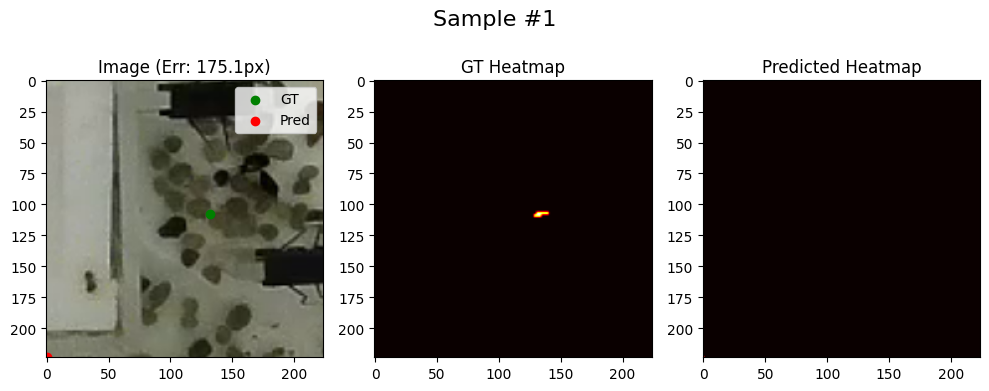

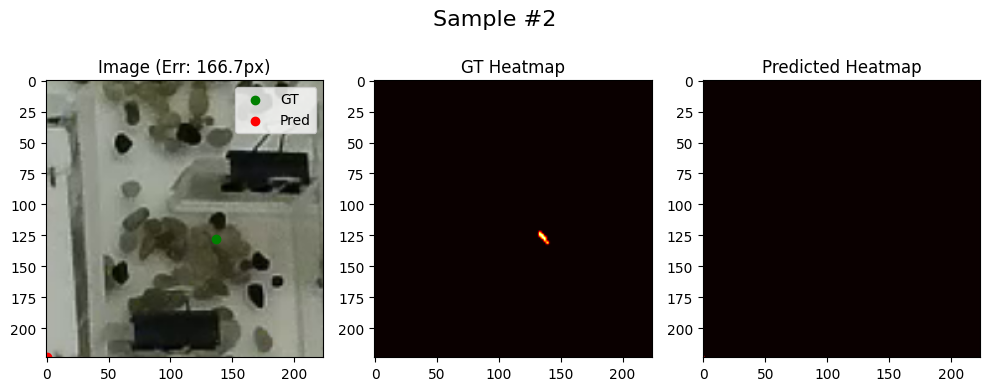

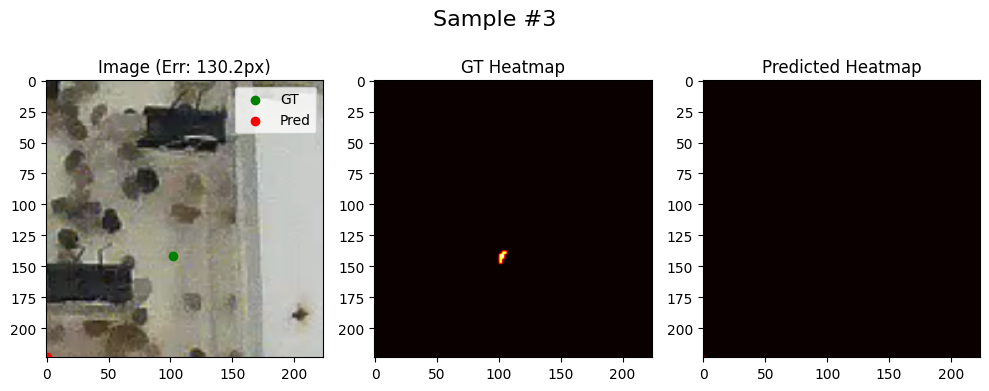

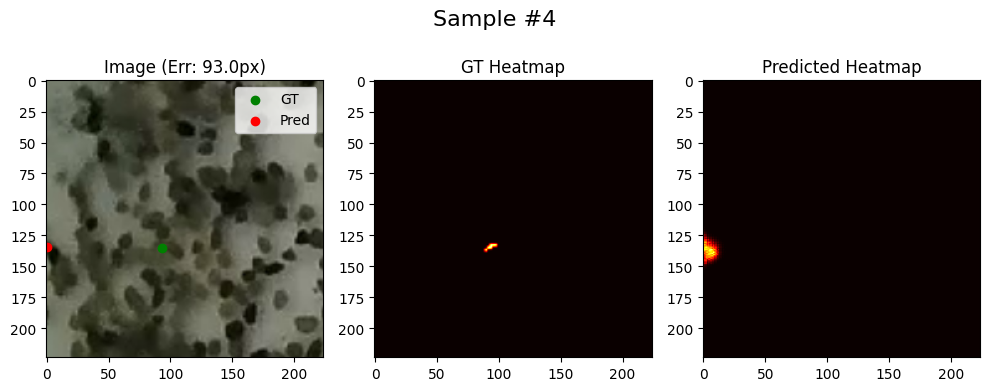

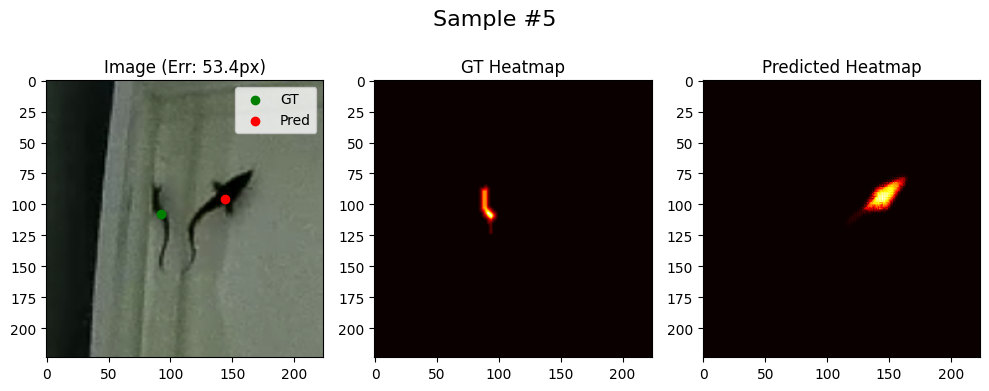

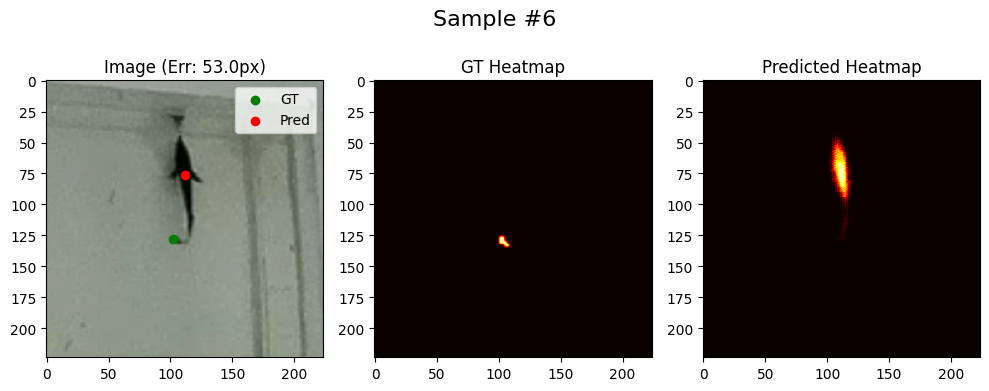

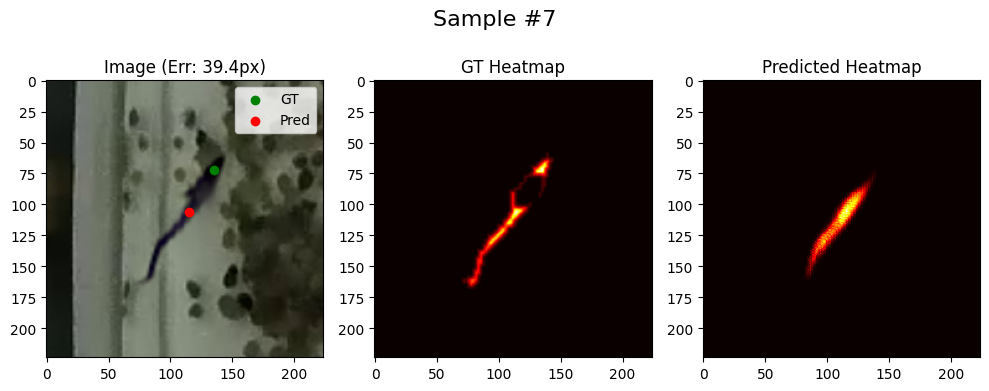

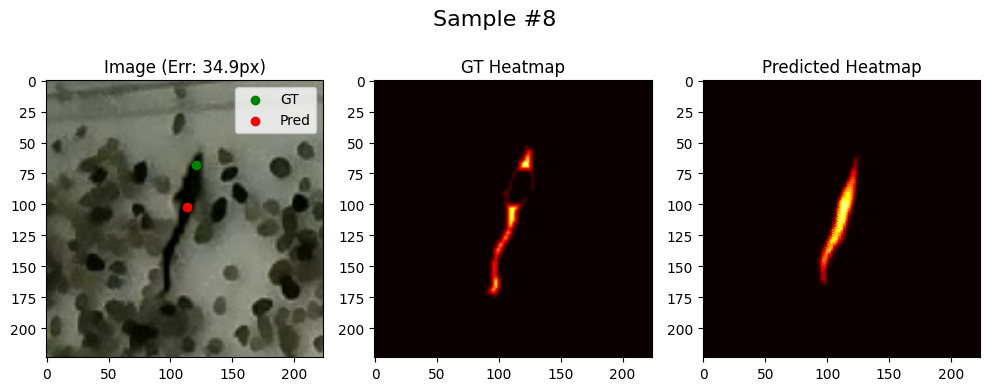

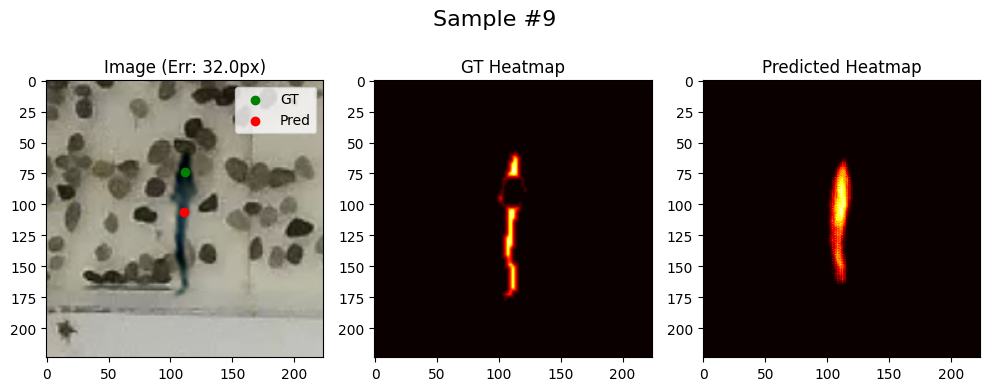

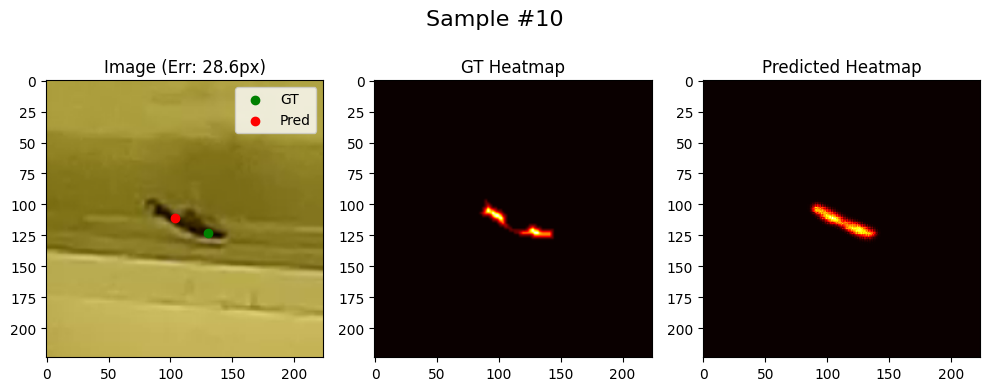

In [14]:
# Show some of the worst predictions
#
# The worst ones are expected to be the outliers in the
# dataset, as we know we have some bad labeling.
for i in range(10):
    show_sample(results[i], index=i+1)

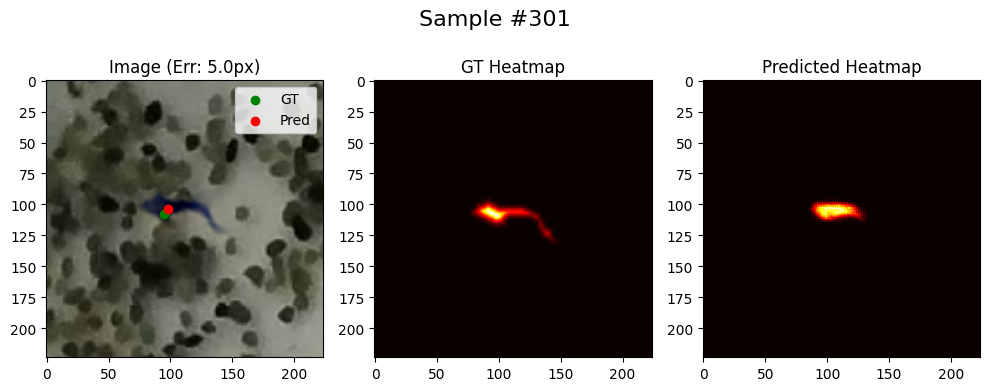

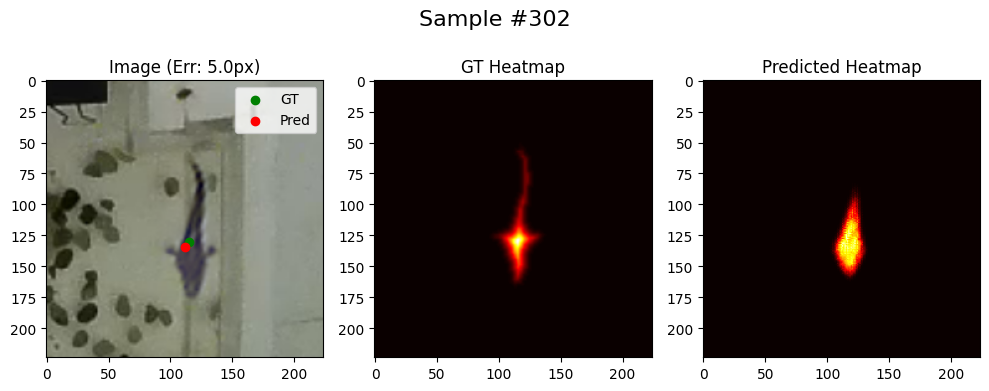

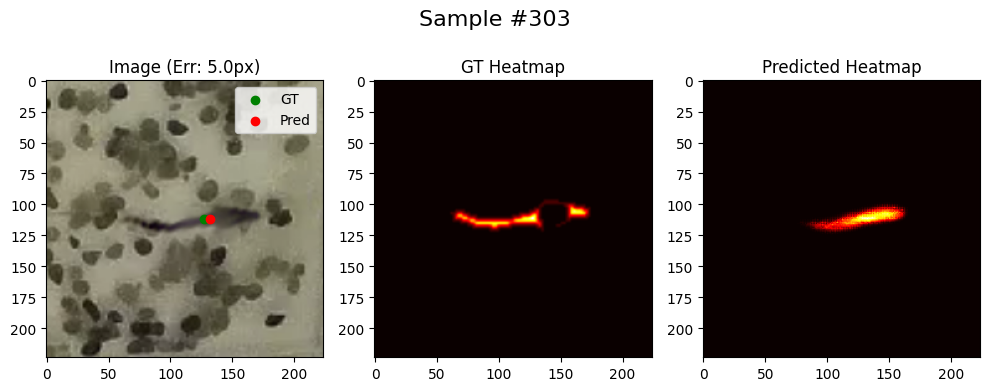

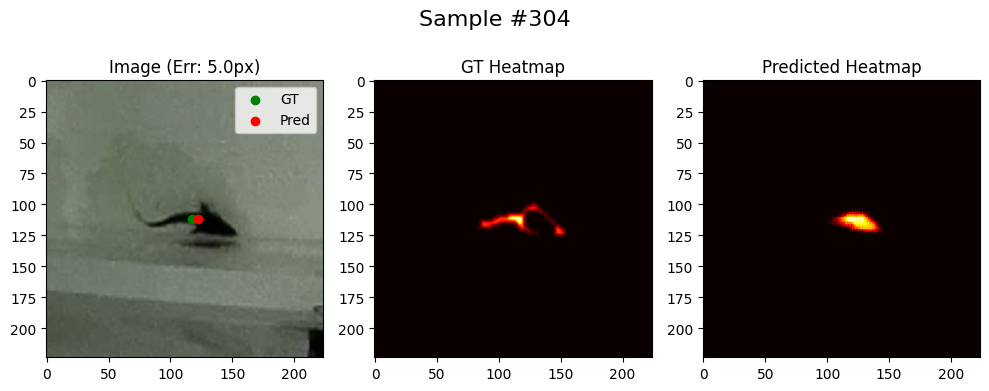

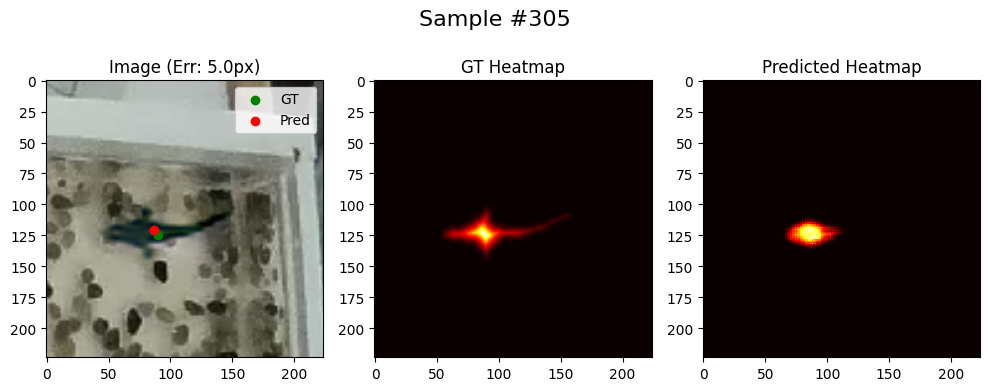

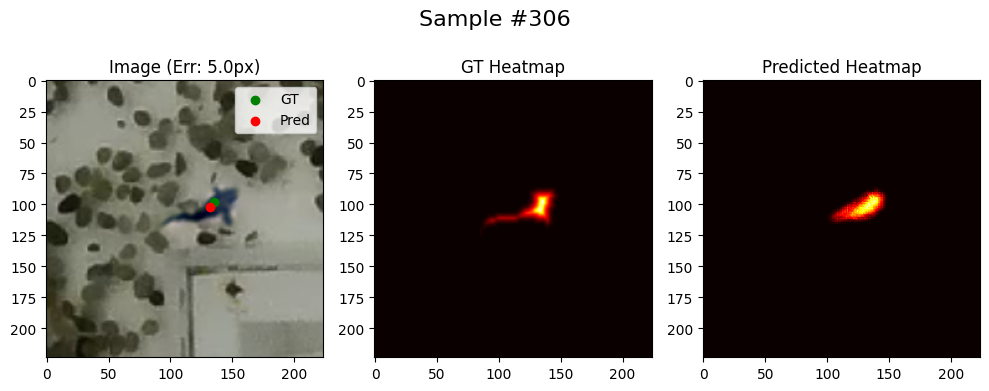

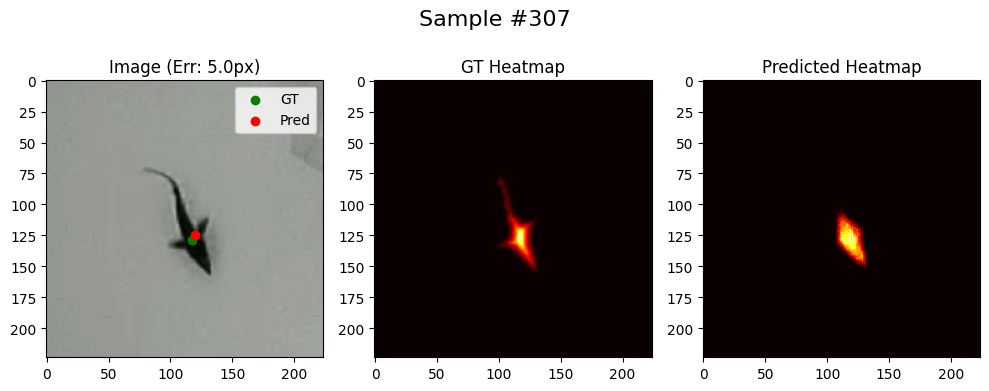

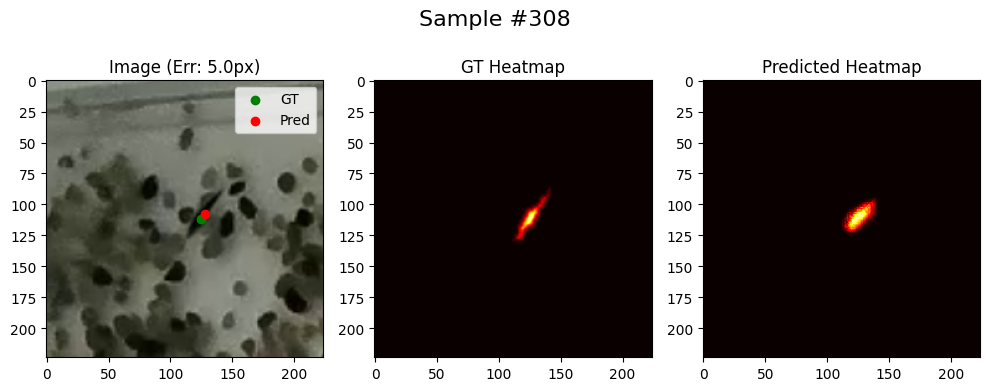

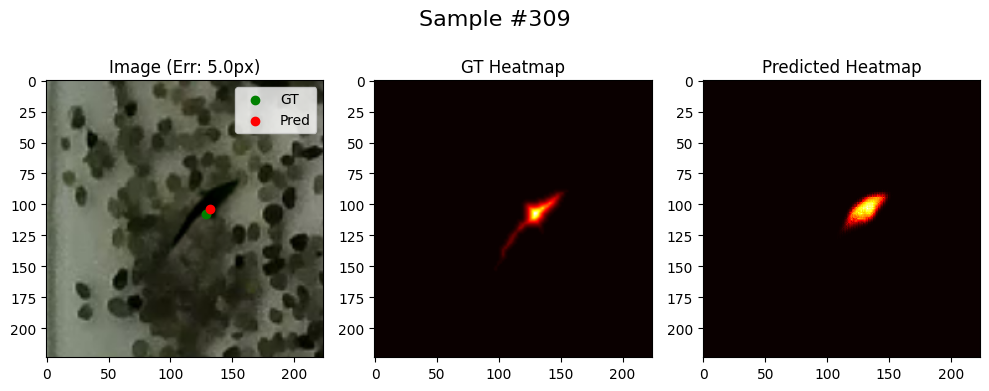

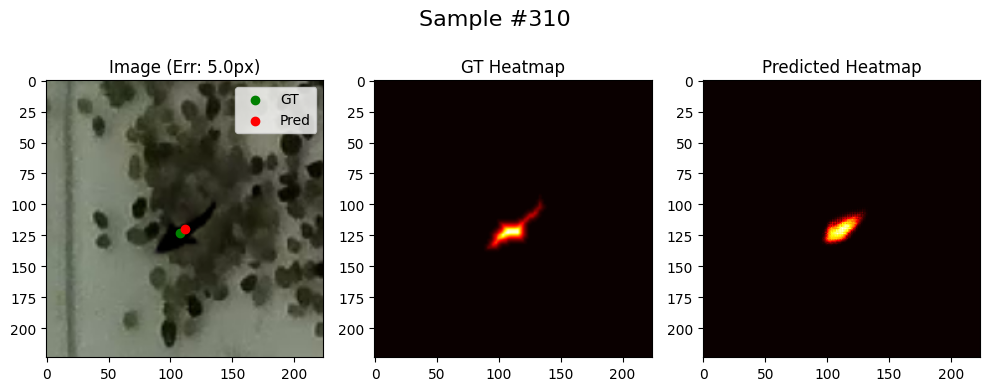

In [15]:
result_size = len(results)
# Show the middle ones
for i in range(result_size//2-5, result_size//2+5):
    show_sample(results[i], index=i+1)

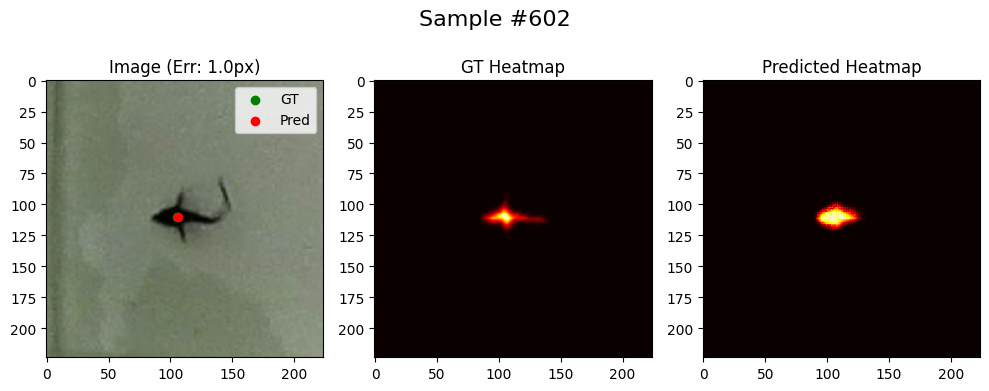

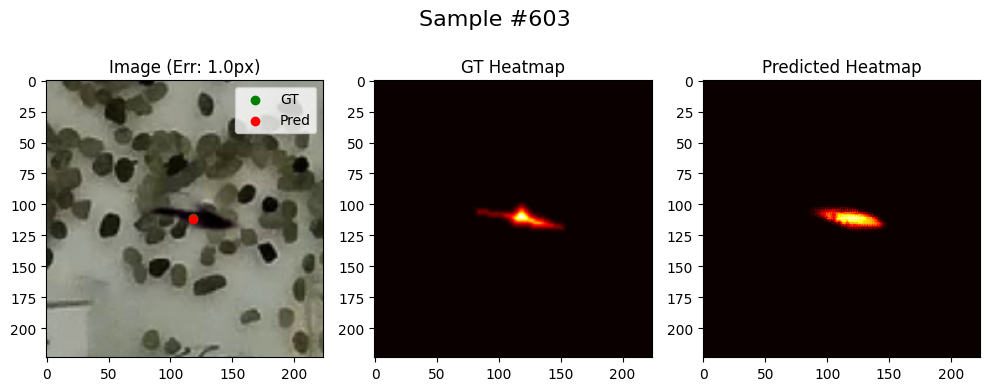

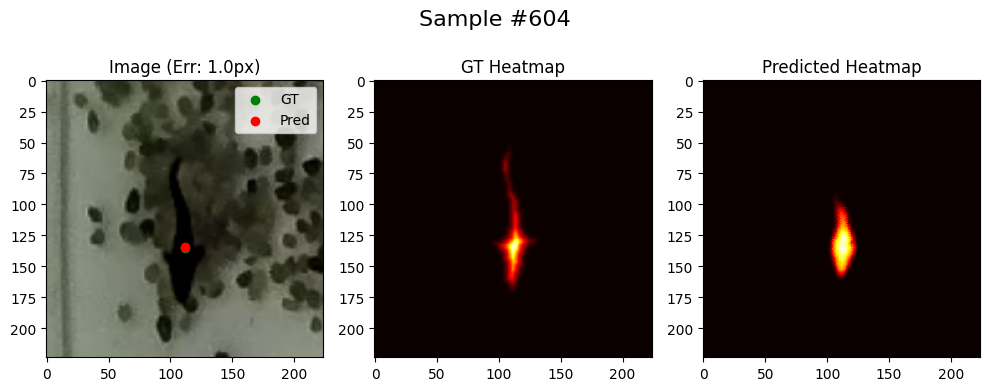

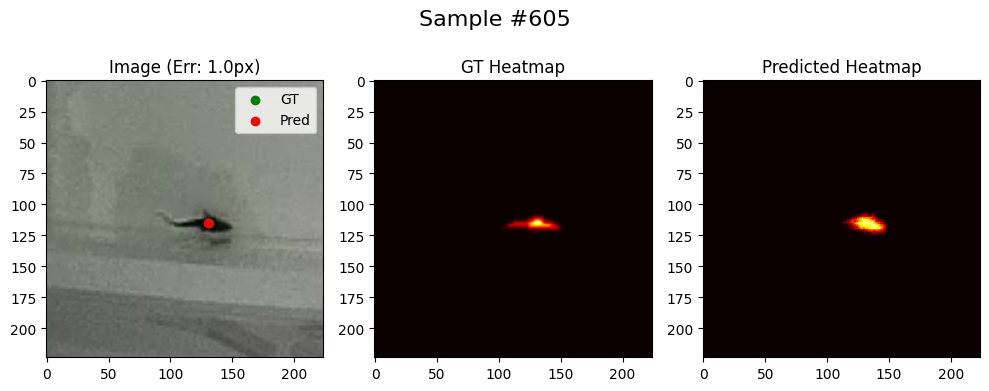

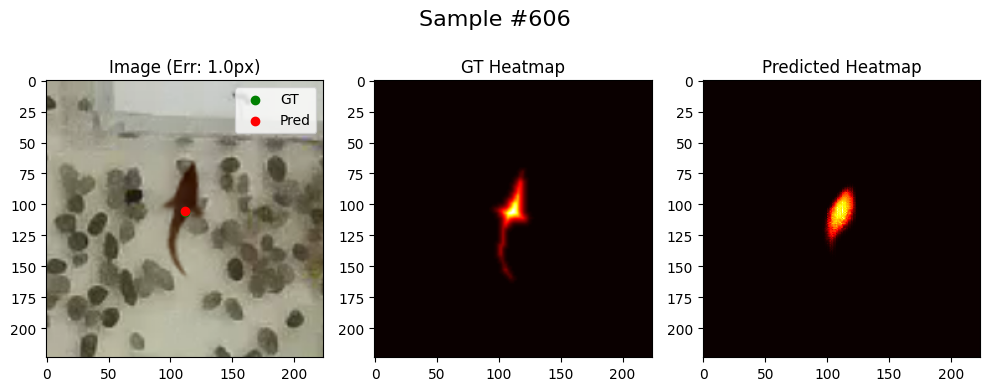

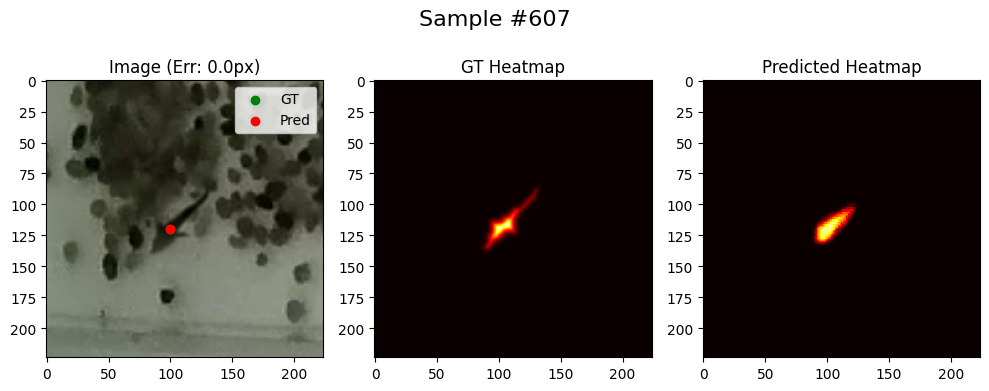

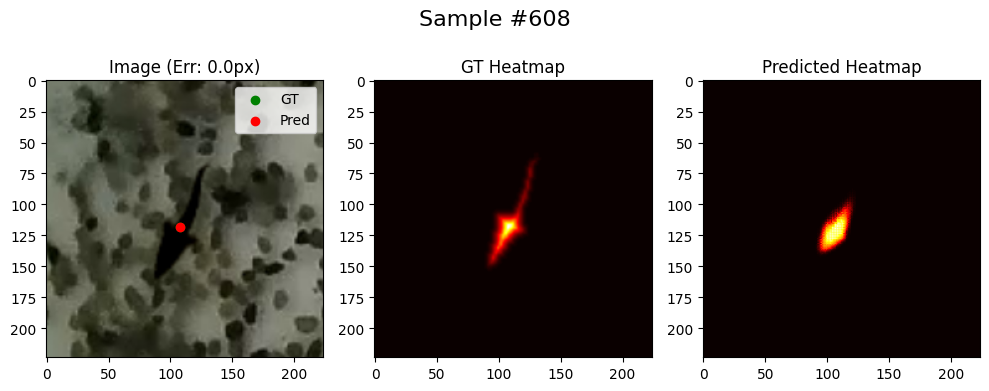

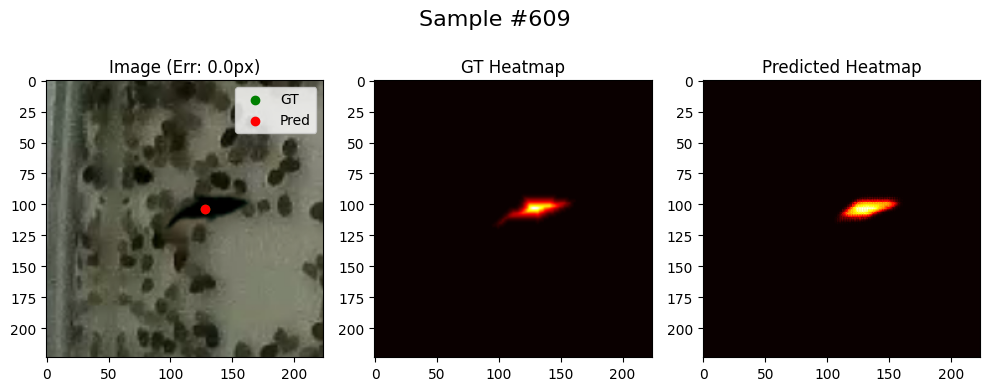

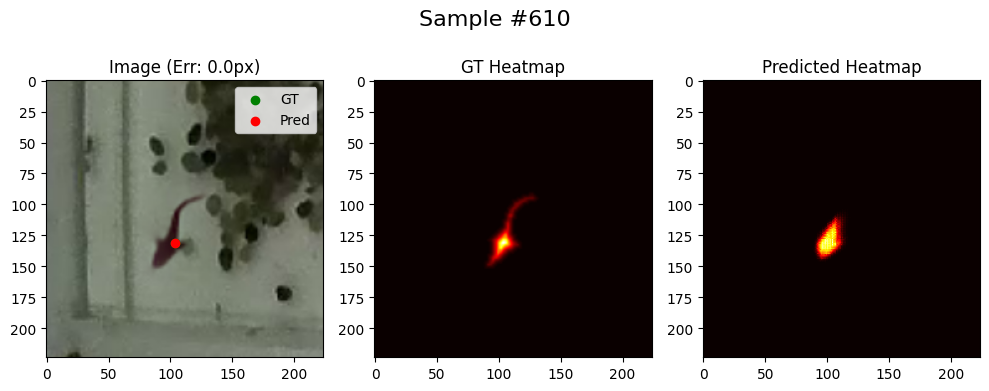

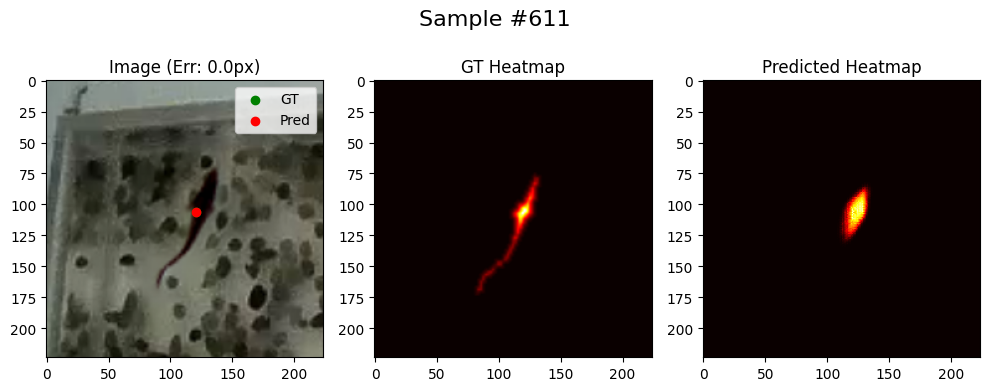

In [16]:
# Show some of the best predictions
for i in range(result_size-10, result_size):
    show_sample(results[i], index=i+1)